In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [88]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

course_1_bak_spec = read_dataset("../../data/datasets/1st_course_bak_spec.csv")
course_1_magistr = read_dataset("../../data/datasets/1st_course_magistr.csv")

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [89]:
X_c1_bak_spec = course_1_bak_spec.drop(columns=["Таргет"])
y_c1_bak_spec = course_1_bak_spec["Таргет"]

X_train_c1_bak_spec, X_test_c1_bak_spec, y_train_c1_bak_spec, y_test_c1_bak_spec = train_test_split(
    X_c1_bak_spec,
    y_c1_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_c1_magistr = course_1_magistr.drop(columns=["Таргет"])
y_c1_magistr = course_1_magistr["Таргет"]

X_train_c1_magistr, X_test_c1_magistr, y_train_c1_magistr, y_test_c1_magistr = train_test_split(
    X_c1_magistr,
    y_c1_magistr,
    test_size=0.2,
    random_state=random_state
)

X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 12}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5,
                                        min_samples_split=12))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       117
           1       0.36      0.94      0.52        17

    accuracy                           0.78       134
   macro avg       0.68      0.85      0.69       134
weighted avg       0.91      0.78      0.82       134



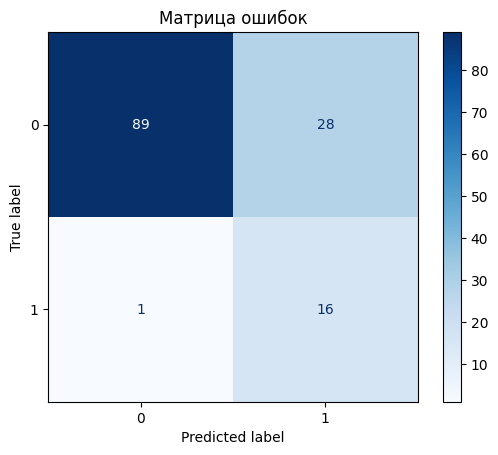

                                            feature  importance
37                      Позиция студента в рейтинге    0.753781
0                                         Приоритет    0.051552
3                                          Контракт    0.049006
7                  Полных лет на момент поступления    0.044264
11                             fromSverdlovskRegion    0.035464
8                         Общее количество пересдач    0.020456
1                            Cумма баллов испытаний    0.017175
9                           Общее количество долгов    0.015727
6                                               Пол    0.012574
2                           Балл за инд. достижения    0.000000
5                      Иностранный абитуриент (МОН)    0.000000
4                             Нуждается в общежитии    0.000000
12                          Human Development Index    0.000000
10                                 fromEkaterinburg    0.000000
14                                  Отде

In [90]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

y_pred_s_magistr = grid_search.predict(X_test_s_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_s_magistr.joblib')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_s_magistr, y_pred_s_magistr))

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_s_magistr.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

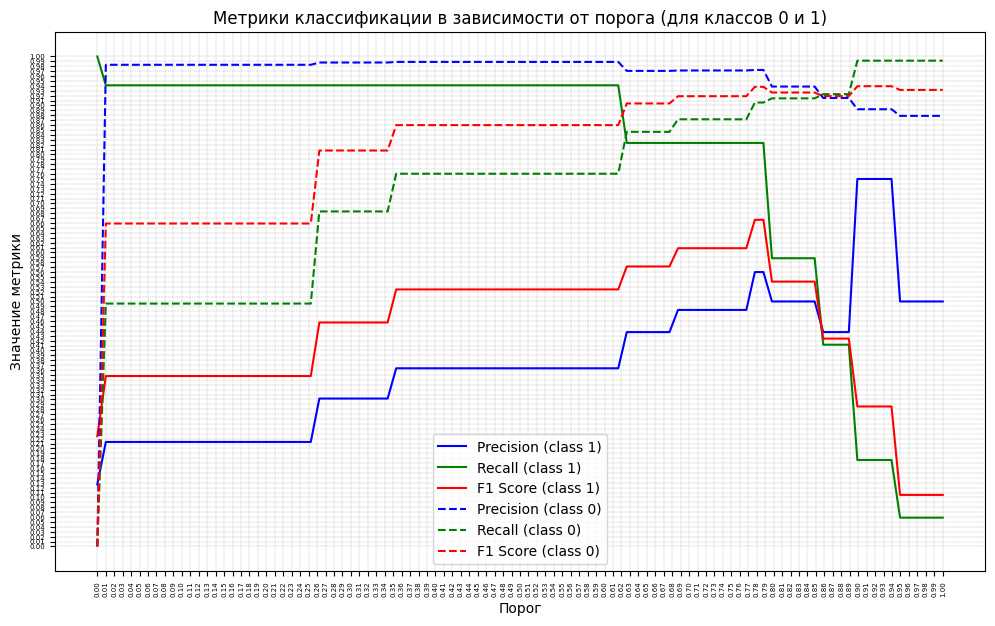

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []

precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))


plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.grid(True)
plt.show()


{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=10))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       271
           1       0.84      0.69      0.76        52

    accuracy                           0.93       323
   macro avg       0.89      0.83      0.86       323
weighted avg       0.93      0.93      0.93       323



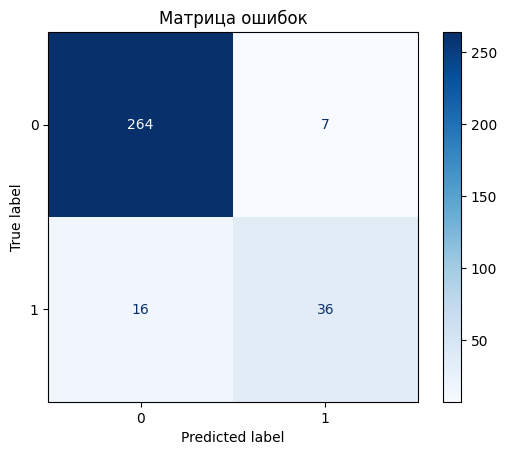

                                            feature  importance
10                          Общее количество долгов    0.715215
39                      Позиция студента в рейтинге    0.181102
1                            Cумма баллов испытаний    0.043492
21                                       Специалист    0.025576
13                          Human Development Index    0.015058
8                  Полных лет на момент поступления    0.010534
0                                         Приоритет    0.004731
20                                     Очно-заочная    0.004291
7                                               Пол    0.000000
6                      Иностранный абитуриент (МОН)    0.000000
5                             Нуждается в общежитии    0.000000
4                                          Контракт    0.000000
3                           Балл за инд. достижения    0.000000
2                                               БВИ    0.000000
11                                 fromE

In [92]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

y_pred_s_bak_spec = grid_search.predict(X_test_s_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_s_bak_spec.joblib')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_s_bak_spec, y_pred_s_bak_spec))

cm = confusion_matrix(y_test_s_bak_spec, y_pred_s_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_s_bak_spec.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

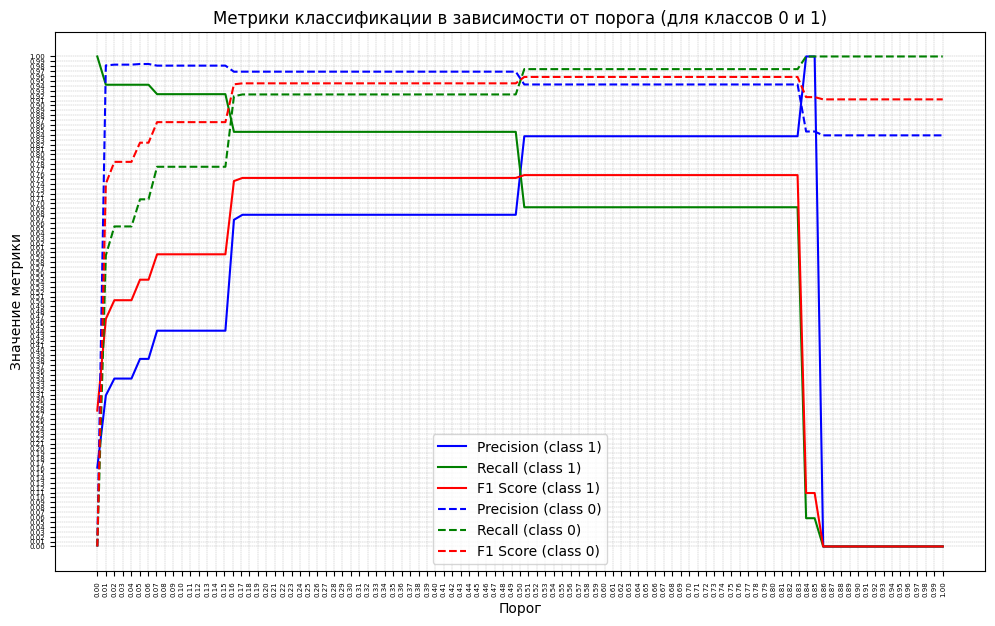

In [93]:
y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []

precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.grid(True)
plt.show()

{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 38, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(max_depth=38))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       117
           1       0.25      0.29      0.27        17

    accuracy                           0.80       134
   macro avg       0.57      0.58      0.58       134
weighted avg       0.81      0.80      0.81       134



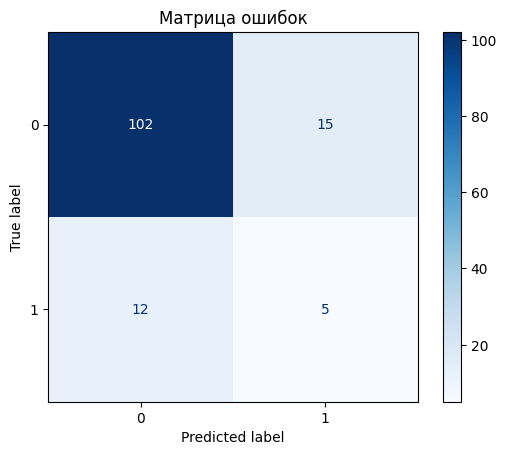

                                            feature  importance
1                            Cумма баллов испытаний    0.400992
7                  Полных лет на момент поступления    0.170266
9                              fromSverdlovskRegion    0.064879
0                                         Приоритет    0.059948
4                             Нуждается в общежитии    0.046754
2                           Балл за инд. достижения    0.040202
29                            Код направления 1: 11    0.034564
10                          Human Development Index    0.027769
30                            Код направления 1: 27    0.027497
3                                          Контракт    0.025053
32                             Код направления 3: 2    0.020829
28                            Код направления 1: 10    0.019316
6                                               Пол    0.018889
33                             Код направления 3: 3    0.014650
8                                  fromE

In [94]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_c1_magistr, y_train_c1_magistr)

y_pred_c1_magistr = grid_search.predict(X_test_c1_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_c1_magistr.joblib')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_magistr, y_pred_c1_magistr))

cm = confusion_matrix(y_test_c1_magistr, y_pred_c1_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_c1_magistr.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

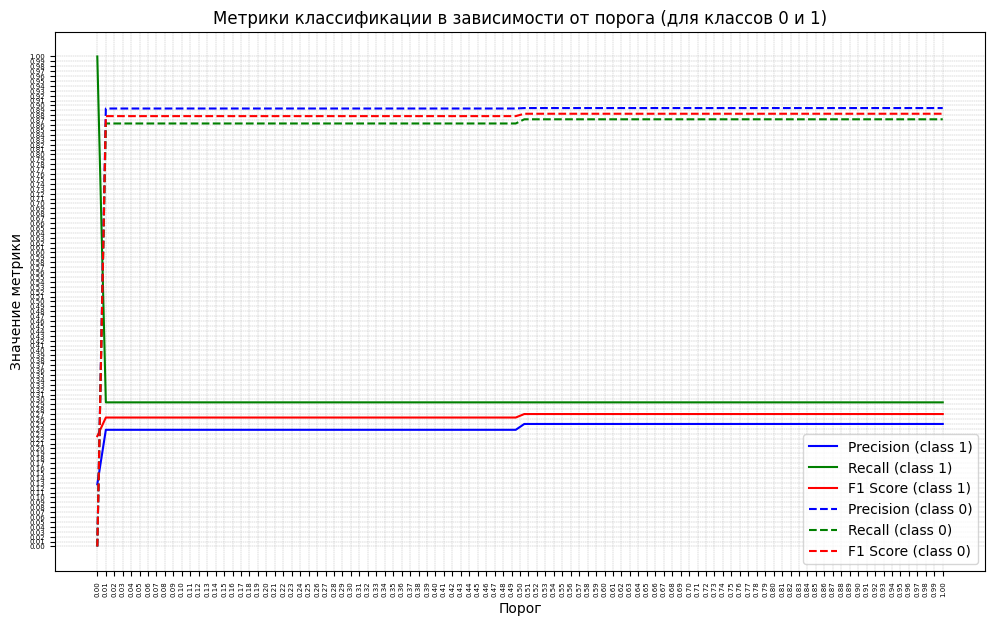

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_probs = grid_search.predict_proba(X_test_c1_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []

precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))


plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.grid(True)
plt.show()

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       271
           1       0.36      0.67      0.47        52

    accuracy                           0.76       323
   macro avg       0.64      0.72      0.66       323
weighted avg       0.83      0.76      0.78       323



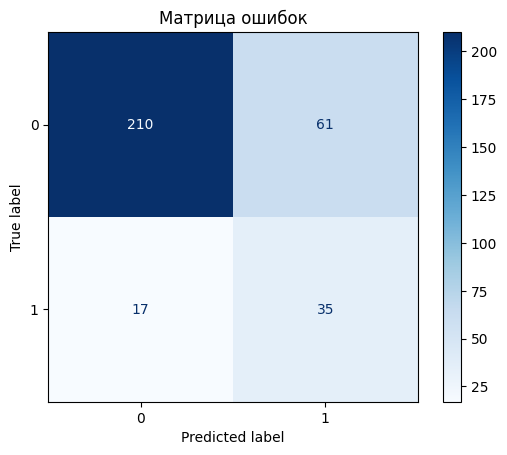

                                            feature  importance
8                  Полных лет на момент поступления    0.355165
1                            Cумма баллов испытаний    0.310124
17                                          Заочная    0.063680
3                           Балл за инд. достижения    0.051024
19                                       Специалист    0.039842
32                            Код направления 1: 27    0.039447
16  олимпиада из перечня, утвержденного МОН РФ (ОШ)    0.031069
9                                  fromEkaterinburg    0.028899
18                                     Очно-заочная    0.023439
6                      Иностранный абитуриент (МОН)    0.017888
12                                     Особая квота    0.016035
31                            Код направления 1: 11    0.008961
7                                               Пол    0.007700
22                                 Профильная Школа    0.006729
4                                       

In [96]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_c1_bak_spec, y_train_c1_bak_spec)

y_pred_c1_bak_spec = grid_search.predict(X_test_c1_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_c1_bak_spec.joblib')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_bak_spec, y_pred_c1_bak_spec))

cm = confusion_matrix(y_test_c1_bak_spec, y_pred_c1_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_c1_bak_spec.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

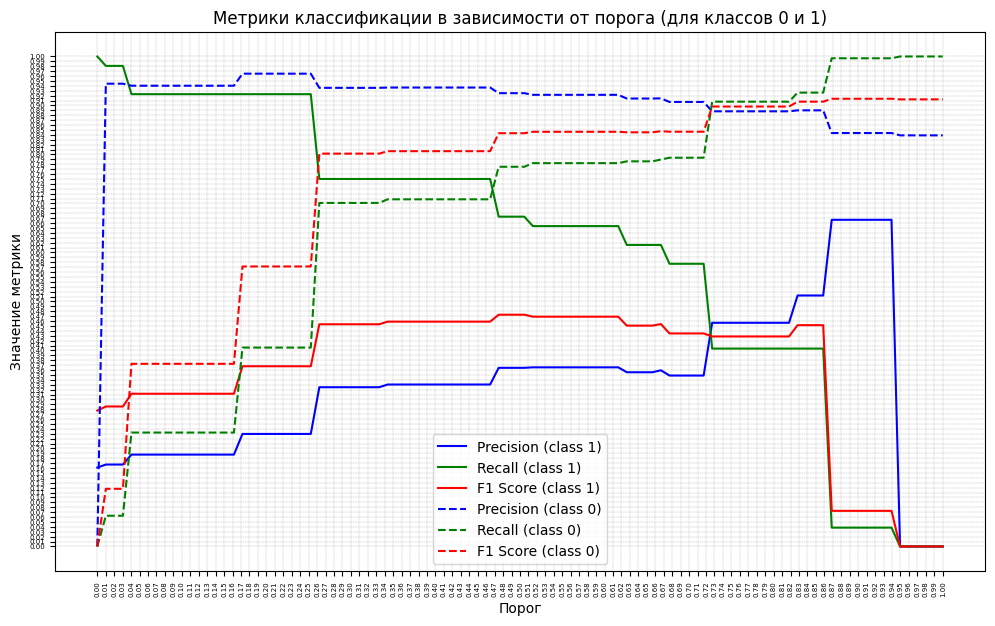

In [97]:
y_probs = grid_search.predict_proba(X_test_c1_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []

precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.grid(True)
plt.show()